In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# Print the classes mapped to each table
print(Base.classes.keys())


['measurement', 'station']


/var/folders/7w/rhfxprsx7d3f562wgs6z_bn80000gn/T/ipykernel_13066/3973378465.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())


['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
# Import necessary modules
from sqlalchemy.orm import Session

# Create the session
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
from sqlalchemy import func

# Find the most recent date in the data set
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the data set is: {most_recent_date}")


The most recent date in the data set is: 2017-08-23


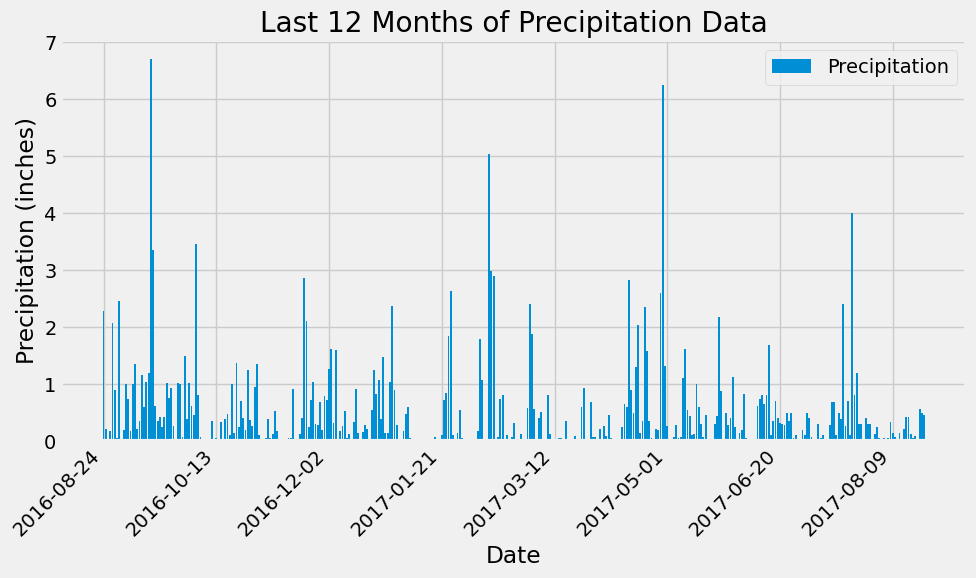

In [10]:
# Design a query to retrieve the last 12 months of precipitation data
# Starting from the most recent data point in the database

# Calculate the date one year from the last date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago from the last date in the dataset
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame
# Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')
plt.xticks(rotation=45, ha='right')  # Rotate the labels for better readability
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Set the maximum number of ticks
plt.legend()
plt.tight_layout()
plt.show()



In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()

# Display the summary statistics
summary_statistics


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
from sqlalchemy import func

# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(func.distinct(Station.station))).scalar()

print(f'Total number of stations: {total_stations}')


Total number of stations: 9


In [13]:
from sqlalchemy import desc

# Design a query to find the most active stations
# List the stations and their counts in descending order
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(desc(func.count(Measurement.station))).all()

# Display the result
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Using the most active station id from the previous query
most_active_station = active_stations[0][0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station).all()

# Display the result
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"Most Active Station: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")


Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


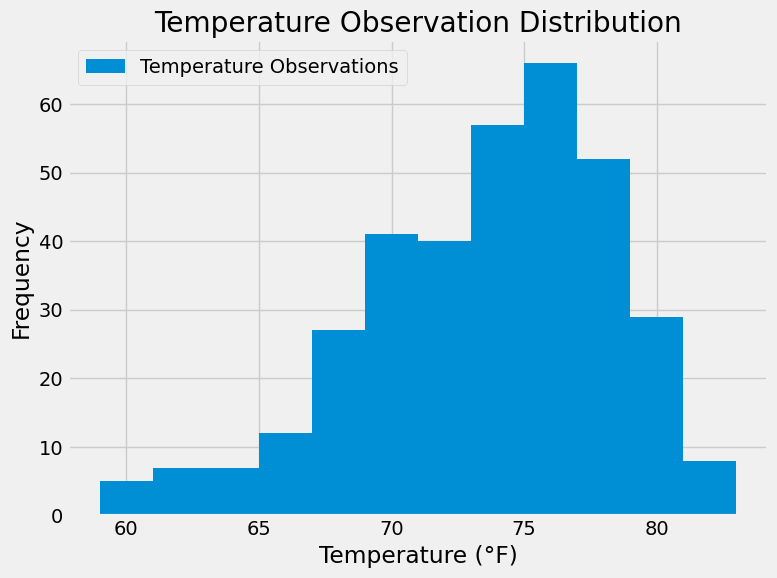

In [15]:
# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, label='Temperature Observations')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Distribution')
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
from flask import Flask, jsonify
from sqlalchemy import create_engine, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
from datetime import datetime

app = Flask(__name__)

@app.route('/')
def home():
    return 'Welcome to the Homepage!'

@app.route('/list_routes')
def list_routes():
    routes = []
    for rule in app.url_map.iter_rules():
        routes.append({
            'endpoint': rule.endpoint,
            'methods': ','.join(rule.methods),
            'path': str(rule),
        })
    return jsonify(routes)

@app.route('/api/v1.0/stations')
def stations():
    # Query all station names
    results = session.query(Station.station).all()

    # Convert the results to a list
    station_list = [result[0] for result in results]

    return jsonify(station_list)

@app.route('/api/v1.0/tobs')
def tobs():
    # Calculate the date one year ago from the latest date in the database
    latest_date = session.query(func.max(Measurement.date)).scalar()
    latest_date = datetime.strptime(latest_date, '%Y-%m-%d')
    one_year_ago = latest_date - timedelta(days=365)

    # Query the most active station
    most_active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]

    # Query temperature observations for the previous year from the most active station
    results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station, Measurement.date >= one_year_ago).all()

    # Convert the results to a list of dictionaries
    tobs_list = [{'date': result[0], 'temperature': result[1]} for result in results]

    return jsonify(tobs_list)

@app.route('/api/v1.0/<start>')
def temperature_start(start):
    # Query TMIN, TAVG, and TMAX for all dates greater than or equal to the start date
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start).all()

    # Convert the results to a dictionary
    temperature_data = {
        'TMIN': results[0][0],
        'TAVG': results[0][1],
        'TMAX': results[0][2]
    }

    return jsonify(temperature_data)

@app.route('/api/v1.0/<start>/<end>')
def temperature_start_end(start, end):
    # Query TMIN, TAVG, and TMAX for the date range from start to end (inclusive)
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start, Measurement.date <= end).all()

    # Convert the results to a dictionary
    temperature_data = {
        'TMIN': results[0][0],
        'TAVG': results[0][1],
        'TMAX': results[0][2]
    }

    return jsonify(temperature_data)

if __name__ == '__main__':
    app.run(debug=True, port=5002)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5002
Press CTRL+C to quit
 * Restarting with watchdog (fsevents)
Traceback (most recent call last):
  File "/Users/nmfidler/opt/anaconda3/envs/dev/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/nmfidler/opt/anaconda3/envs/dev/lib/python3.10/site-packages/traitlets/config/application.py", line 991, in launch_instance
    app.initialize(argv)
  File "/Users/nmfidler/opt/anaconda3/envs/dev/lib/python3.10/site-packages/traitlets/config/application.py", line 113, in inner
    return method(app, *args, **kwargs)
  File "/Users/nmfidler/opt/anaconda3/envs/dev/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 689, in initialize
    self.init_sockets()
  File "/Users/nmfidler/opt/anaconda3/envs/dev/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 328, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.shell_port)
  File "/Users/nmfidler/opt/anaco

SystemExit: 1

# Close Session

In [ ]:
# Close Session
session.close()